# 12-06 BiLSTM-CRF를 이용한 개체명 인식

기존의 양방향 LSTM 모델에 CRF(Conditional Random Field)라는 새로운 층을 추가하여 보다 모델을 개선시킨 양방향 LSTM + CRF 모델을 사용하여 개체명 인식(Named Entity Recognition)을 수행

## CRF(Conditional Random Field)

CRF 층을 추가하면 모델은 예측 개체명, 다시 말해 레이블 사이의 의존성을 고려할 수 있습니다.  

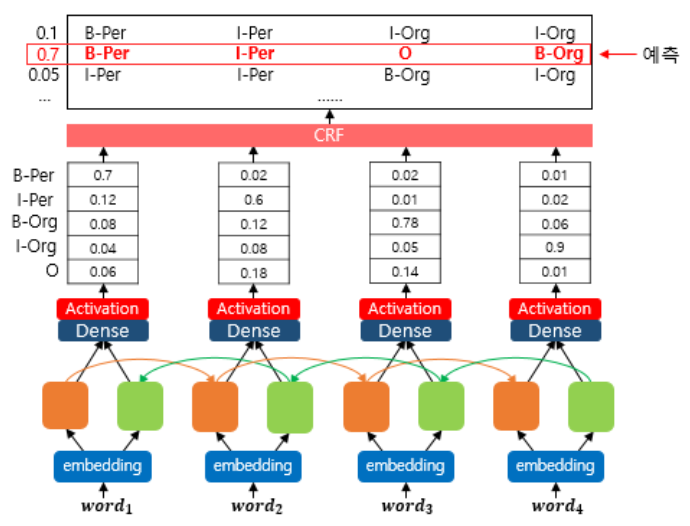  
기존에 CRF 층이 존재하지 않았던 양방향 LSTM 모델은 활성화 함수를 지난 시점에서 개체명을 결정했지만, CRF 층을 추가한 모델에서는 활성화 함수의 결과들이 CRF 층의 입력으로 전달됩니다. CRF 층은 레이블 시퀀스에 대해서 가장 높은 점수를 가지는 시퀀스를 예측합니다.  

이러한 구조에서 CRF 층은 점차적으로 훈련 데이터로부터 아래와 같은 제약사항 등을 학습하게 됩니다.
- 문장의 첫번째 단어에서는 I가 나오지 않습니다.
- O-I 패턴은 나오지 않습니다.
- B-I-I 패턴에서 개체명은 일관성을 유지합니다. 예를 들어 B-Per 다음에 I-Org는 나오지 않습니다.  

요약하면 양방향 LSTM은 입력 단어에 대한 양방향 문맥을 반영하며, CRF는 출력 레이블에 대한 양방향 문맥을 반영합니다.

## CRF 층 설치하기

In [2]:
pip install keras-crf

Note: you may need to restart the kernel to use updated packages.


##  BiLSTM-CRF를 이용한 개체명 인식

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, TimeDistributed, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_crf import CRFModel
from seqeval.metrics import f1_score, classification_report

embedding_dim = 128
hidden_units = 64
dropout_ratio = 0.3

sequence_input = Input(shape=(max_len,),dtype=tf.int32, name='sequence_input')

model_embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_len)(sequence_input)

model_bilstm = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(model_embedding)

model_dropout = TimeDistributed(Dropout(dropout_ratio))(model_bilstm)

model_dense = TimeDistributed(Dense(tag_size, activation='relu'))(model_dropout)

base = Model(inputs=sequence_input, outputs=model_dense)
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

NameError: name 'max_len' is not defined

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es]) # . keras-crf가 원-핫 인코딩 된 레이블은 지원하지 않으므로 y_train이 아니라 y_train_int를 사용

In [ ]:
model.load_weights('bilstm_crf/cp.ckpt')

i = 13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = model.predict(np.array([X_test[i]]))[0] # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
labels = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
    if word != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[word], index_to_ner[tag], index_to_ner[pred]))

In [ ]:
y_predicted = model.predict(X_test)[0]

In [ ]:
def sequences_to_tag_for_crf(sequences): 
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences: 
        word_sequence = []
        # 시퀀스로부터 예측 정수 레이블을 하나씩 꺼낸다.
        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

pred_tags = sequences_to_tag_for_crf(y_predicted)
test_tags = sequences_to_tag(y_test)

print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))
print(classification_report(test_tags, pred_tags))